# Introduction to Recurrent Neural Networks

In [4]:
using Knet

## A one layer MLP vs a simple RNN

([Elman 1990](http://onlinelibrary.wiley.com/doi/10.1207/s15516709cog1402_1/pdf)) A simple RNN takes the previous hidden state as an extra input, and returns the next hidden state as an output.

In [5]:
# Comparison of a single MLP layer and corresponding RNN

function tanhmlp(param, input)
    weight,bias = param
    return tanh(input * weight .+ bias)
end

function tanhrnn(param, input, state)
    weight,bias = param
    return tanh(hcat(input, state) * weight .+ bias)
end;

<img src="images/rnn-vs-mlp.png" />(<a href="https://docs.google.com/drawings/d/1bPttFA0GEh7ti3xoWDma1ZbrQ21eulsPDeVUbPgdA7g/edit?usp=sharing">image source</a>)

## Architectures

<img src="images/diags.png" />
(<a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness">image source</a>)

## Long Short-Term Memory (LSTM)
([Hochreiter and Schmidhuber, 1997](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf))
LSTM is a more sophisticated RNN module that performs better with long-range dependencies. 

<img src="images/LSTM3-chain.png" width=800 />
([image source](http://colah.github.io/posts/2015-08-Understanding-LSTMs))



$$\begin{align}
f_t &= \sigma(W_f\cdot[h_{t-1},x_t] + b_f) & \text{forget gate} \\
i_t &= \sigma(W_i\cdot[h_{t-1},x_t] + b_i) & \text{input gate} \\
\tilde{C}_t &= \tanh(W_C\cdot[h_{t-1},x_t] + b_C) & \text{cell candidate} \\
C_t &= f_t \ast C_{t-1} + i_t \ast \tilde{C}_t & \text{new cell} \\
o_t &= \sigma(W_o\cdot[h_{t-1},x_t] + b_o) & \text{output gate} \\
h_t &= o_t \ast \tanh(C_t) & \text{new output}\\
\end{align}$$

## A pure Julia LSTM implementation

In [6]:
function lstm(param, input, state)
    weight,bias = param
    hidden,cell = state
    h       = size(hidden,2)
    gates   = hcat(input,hidden) * weight .+ bias
    forget  = sigm.(gates[:,1:h])
    ingate  = sigm.(gates[:,1+h:2h])
    outgate = sigm.(gates[:,1+2h:3h])
    change  = tanh.(gates[:,1+3h:4h])
    cell    = cell .* forget + ingate .* change
    hidden  = outgate .* tanh.(cell)
    return (hidden,cell)
end;

## Gated Recurrent Unit (GRU)

Introduced by <a href="http://arxiv.org/pdf/1406.1078v3.pdf">Cho, et al. (2014)</a>, GRU combines the forget and input gates into a single “update gate.”

<img src="images/LSTM3-var-GRU.png" />
(<a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">image source</a>)



## A more efficient cuDNN based implementation: Knet.RNN

In [7]:
using Knet: RNN
@doc RNN

```
rnn = RNN(inputSize, hiddenSize; opts...)
rnn(x; hidden, batchSizes) => y
```

`RNN` returns a callable RNN object `rnn`. Given a minibatch of sequences `x`, `rnn(x)` returns `y`, the hidden states of the final layer for each time step.

**Dimensions:** The input `x` can be 1, 2, or 3 dimensional and `y` will have the same number of dimensions as `x`. size(x)=(X,[B,T]) and size(y)=(H/2H,[B,T]) where X is inputSize, H is hiddenSize, B is batchSize, T is seqLength. By default a 1-D `x` represents a single instance for a single time step, a 2-D `x` represents a single minibatch for a single time step, and a 3-D `x` represents a sequence of identically sized minibatches for multiple time steps. The output `y` gives the hidden state (of the final layer for multi-layer RNNs) for each time step, its first dimension is H for unidirectional and 2H for bidirectional RNNs.

**batchSizes:** If `batchSizes=nothing` (default), all sequences in a minibatch are assumed to be the same length. If `batchSizes` is an array of (non-increasing) integers, it gives us the batch size for each time step (allowing different sequences in the minibatch to have different lengths). In this case `x` will typically be 2-D with the second dimension representing variable size batches for time steps. If `batchSizes` is used, `sum(batchSizes)` should equal `length(x) ÷ size(x,1)`.

**Hidden states:** If `hidden=nothing` (default), initial hidden states are assumed zero and final hidden states are discarded. If `hidden=Any[]`, initial hidden states are assumed zero and final hidden states are pushed into hidden.  If `hidden=Any[h,c]` (for LSTM) or `hidden=Any[h]` (for others), the values in the hidden array are taken to be the initial hidden states and are replaced by the final hidden states on return.  Note that the final time step of `y` always contains the final hidden state of the last layer, so `hidden` will return no extra information for a single layer network.  All hidden and cell states have dimensionality (H,B,L) for unidirectional and (H,B,2L) for bidirectional RNNs.  If `batchSizes` is used and minibatch sizes change over time, B is always taken to be the size of the first minibatch for hidden sizes.

**Keyword arguments for RNN:**

  * `rnnType=:lstm` Type of RNN: One of :relu, :tanh, :lstm, :gru.
  * `numLayers=1`: Number of RNN layers.
  * `bidirectional=false`: Create a bidirectional RNN if `true`.
  * `dropout=0`: Dropout probability. Ignored if `numLayers==1`.
  * `skipInput=false`: Do not multiply the input with a matrix if `true`.
  * `dataType=Float32`: Data type to use for weights.
  * `algo=0`: Algorithm to use, see CUDNN docs for details.
  * `seed=0`: Random number seed for dropout. Uses `time()` if 0.
  * `winit=xavier`: Weight initialization method for matrices.
  * `binit=zeros`: Weight initialization method for bias vectors.
  * `usegpu=(gpu()>=0)`: GPU used by default if one exists.

**Formulas:** RNNs compute the output h[t] for a given iteration from the recurrent input h[t-1] and the previous layer input x[t] given matrices W, R and biases bW, bR from the following equations:

`:relu` and `:tanh`: Single gate RNN with activation function f:

```
h[t] = f(W * x[t] .+ R * h[t-1] .+ bW .+ bR)
```

`:gru`: Gated recurrent unit:

```
i[t] = sigm(Wi * x[t] .+ Ri * h[t-1] .+ bWi .+ bRi) # input gate
r[t] = sigm(Wr * x[t] .+ Rr * h[t-1] .+ bWr .+ bRr) # reset gate
n[t] = tanh(Wn * x[t] .+ r[t] .* (Rn * h[t-1] .+ bRn) .+ bWn) # new gate
h[t] = (1 - i[t]) .* n[t] .+ i[t] .* h[t-1]
```

`:lstm`: Long short term memory unit with no peephole connections:

```
i[t] = sigm(Wi * x[t] .+ Ri * h[t-1] .+ bWi .+ bRi) # input gate
f[t] = sigm(Wf * x[t] .+ Rf * h[t-1] .+ bWf .+ bRf) # forget gate
o[t] = sigm(Wo * x[t] .+ Ro * h[t-1] .+ bWo .+ bRo) # output gate
n[t] = tanh(Wn * x[t] .+ Rn * h[t-1] .+ bWn .+ bRn) # new gate
c[t] = f[t] .* c[t-1] .+ i[t] .* n[t]               # cell output
h[t] = o[t] .* tanh(c[t])
```


In [8]:
using Knet; Knet.gpu(0)

0

In [9]:
ENV["COLUMNS"] = 92
using Knet: train!, Train, Adam

In [10]:
# Download data
using Knet: Knet
include(Knet.dir("data/nltk.jl"))
@doc brown

```
brown()
```

Return (data, words, tags) where data is an array of (x,y) pairs, each pair represents a sentence, x is an UInt16 array of word ids, y is an UInt16 array of postag ids. words and tags are String arrays to convert word and tag ids to strings. Ids are assigned in order of frequency, i.e. words[1] is the most frequent word.


In [11]:
(data,words,tags) = brown()
length.((data,words,tags))

(57340, 56057, 472)

In [12]:
(x,y) = first(data)
@show x
@show y
@show words[x]
@show tags[y];

x = UInt16[0x000f, 0x16e4, 0x0510, 0x15dd, 0x443c, 0x003c, 0x075e, 0x0023, 0x0a31, 0x0004, 0x456e, 0x0254, 0x0491, 0x05fc, 0x04bc, 0x000d, 0x0044, 0x01de, 0x000e, 0x0009, 0x0055, 0x2714, 0x00dd, 0x00bd, 0x0003]
y = UInt16[0x0003, 0x0028, 0x0015, 0x0027, 0x0015, 0x000d, 0x003a, 0x0003, 0x0001, 0x0002, 0x0030, 0x0004, 0x0001, 0x0001, 0x000d, 0x001c, 0x0003, 0x0001, 0x001d, 0x000e, 0x002e, 0x0007, 0x000d, 0x0001, 0x0005]
words[x] = ["The", "Fulton", "County", "Grand", "Jury", "said", "Friday", "an", "investigation", "of", "Atlanta's", "recent", "primary", "election", "produced", "``", "no", "evidence", "''", "that", "any", "irregularities", "took", "place", "."]
tags[y] = ["at", "np-tl", "nn-tl", "jj-tl", "nn-tl", "vbd", "nr", "at", "nn", "in", "np\$", "jj", "nn", "nn", "vbd", "``", "at", "nn", "''", "cs", "dti", "nns", "vbd", "nn", "."]


In [13]:
# Concatenate all sentences, minibatching a bit complicated otherwise
second(x)=x[2]
allx = vcat(first.(data)...)
ally = vcat(second.(data)...)
length.((allx,ally))

(1161192, 1161192)

In [97]:
CORPUSSIZE = length(allx)
NUMWORDS = length(words)
NUMTAGS = length(tags)
EMBEDSIZE = 512
BATCHSIZE = 64
SEQLENGTH = 32
HIDDENSIZE = EMBEDSIZE

512

In [98]:
function seqbatch(x,y,B,T)
    N = length(x) ÷ B
    x = permutedims(reshape(x[1:N*B],N,B))
    y = permutedims(reshape(y[1:N*B],N,B))
    minibatch(x,y,T)
end

seqbatch (generic function with 1 method)

In [99]:
d = seqbatch(allx,ally,BATCHSIZE,SEQLENGTH)
(x,y) = first(d)
@show summary.(first(d))

summary.(first(d)) = ("64×32 Array{UInt16,2}", "64×32 Array{UInt16,2}")


("64×32 Array{UInt16,2}", "64×32 Array{UInt16,2}")

In [100]:
dd = collect(d)
display(words[dd[1][1]])
display(words[dd[2][1]])

64×32 Array{String,2}:
 "The"              "Fulton"    "County"         …  "term-end"     "presentments" 
 "director"         "of"        "architecture"      "gifts"        "from"         
 "local"            "club"      "to"                "who"          "will"         
 "."                "The"       "judge"             "of"           "the"          
 "plans"            "titled"    "``"                "this"         "fall"         
 "admitted"         "for"       "next"           …  "''"           "."            
 "American"         "system"    "?"                 "patriotic"    "apprehensions"
 "of"               "the"       "King"              "Then"         "cometh"       
 "the"              "misdeeds"  "of"                "is"           "entitled"     
 "entertaining"     "and"       "irresponsible"     "from"         "these"        
 "is"               "merely"    "more"           …  "to"           "the"          
 "is"               "not"       "only"              "that"      

64×32 Array{String,2}:
 "that"      "the"         "City"        "Executive"    …  "which"     "the"         
 "the"       "contractor"  "."           "Managing"        "would"     "sue"         
 "meet"      "with"        "the"         "probate"         "closed"    "for"         
 "trial"     ","           "the"         "jury"            "he"        "had"         
 "in"        "four"        "languages"   ":"               "The"       "week"        
 "The"       "evidence"    "in"          "court"        …  "a"         "simple"      
 "of"        "Americans"   "in"          "a"               "tropical"  "green"       
 "Jesus"     "from"        "Galilee"     "to"              ","         "and"         
 "to"        "stay"        "put"         "."               "Burma"     "as"          
 "pages"     "is"          "that"        "the"             "."         "One"         
 "detailed"  "accents"     ","           "phrasings"    …  "of"        "contemporary"
 "progress"  "towards"     "pea

In [101]:
dtst = dd[1:10]
dtrn = dd[11:end]
length.((dtrn,dtst))

(556, 10)

In [102]:
struct Embed; w; end
Embed(vocab::Int,embed::Int) = Embed(param(embed,vocab))
(e::Embed)(x;o...) = e.w[:,x]

In [103]:
(x,y) = first(dtrn)
emb = Embed(length(tags),EMBEDSIZE)
emby = emb(y)
summary(emby)  # (X,B,T)

"512×64×32 KnetArray{Float32,3}"

In [104]:
struct FC; w; b; f; end
FC(input::Int,output::Int,f::Function=identity) = FC(param(output,input),param(output),f)
resize1(x) = reshape(x,size(x,1),:)
(fc::FC)(x;o...) = fc.f.(fc.w * resize1(x) .+ fc.b)

In [105]:
struct Chain; layers; end
Chain(layer1,layer2,layers...)=Chain((layer1,layer2,layers...))
(c::Chain)(x;o...) = (for l in c.layers; x = l(x;o...); end; x)

In [106]:
(x,y) = first(dtrn)

(UInt16[0x1bca 0x04c0 … 0x196b 0x0be1; 0x0291 0x0008 … 0x1973 0x0002; … ; 0x0006 0x008e … 0x0aec 0x0003; 0x79d4 0x010d … 0x0271 0x0004], UInt16[0x0010 0x0007 … 0x0057 0x0001; 0x003e 0x004f … 0x000a 0x0006; … ; 0x0012 0x000b … 0x000d 0x0005; 0x0004 0x0007 … 0x0001 0x0002])

In [107]:
Tagger0(vocab,embed,hidden,output)=Chain(Embed(vocab,embed),FC(embed,hidden,relu),FC(hidden,output))
tag = Tagger0(length(words),EMBEDSIZE,HIDDENSIZE,length(tags))
summary(tag(x))

"472×2048 KnetArray{Float32,2}"

In [108]:
Tagger1(vocab,embed,hidden,output)=Chain(Embed(vocab,embed),RNN(embed,hidden),FC(hidden,output))
tag = Tagger1(length(words),EMBEDSIZE,HIDDENSIZE,length(tags))
summary(tag(x))

"472×2048 KnetArray{Float32,2}"

In [109]:
Tagger2(vocab,embed,hidden,output)=Chain(Embed(vocab,embed),RNN(embed,hidden,bidirectional=true),FC(2hidden,output))
tag = Tagger2(length(words),EMBEDSIZE,HIDDENSIZE,length(tags))
summary(tag(x))

"472×2048 KnetArray{Float32,2}"

In [110]:
t0 = Tagger0(length(words),EMBEDSIZE,HIDDENSIZE,length(tags))
r0 = Train(0:100:2500,dtst)
@time train!(t0, dtrn; optimizer=Adam(), callback=r0); Knet.gc()
minimum.((r0.losses..., r0.errors...))

Progress: 100%|█████████████████████████████████████████████████████| Time: 0:01:15


 75.043434 seconds (2.69 M allocations: 1.214 GiB, 63.36% gc time)


(0.2994007468223572, 0.10312500000000002)

In [111]:
t1 = Tagger1(length(words),EMBEDSIZE,HIDDENSIZE,length(tags))
r1 = Train(0:100:2500,dtst)
@time train!(t1, dtrn; optimizer=Adam(), callback=r1); Knet.gc()
minimum.((r1.losses..., r1.errors...))

Progress: 100%|█████████████████████████████████████████████████████| Time: 0:01:42


101.722237 seconds (2.61 M allocations: 1.216 GiB, 52.71% gc time)


(0.2283434122800827, 0.06787109375)

In [112]:
t1a = Tagger1(length(words),EMBEDSIZE,HIDDENSIZE,length(tags))
r1a = Train(0:100:2500,dtst); h1a = []
@time train!(t1a, dtrn; optimizer=Adam(), callback=r1a, hidden=h1a); Knet.gc()
minimum.((r1a.losses..., r1a.errors...))

Progress: 100%|█████████████████████████████████████████████████████| Time: 0:01:41


101.454082 seconds (2.90 M allocations: 1.228 GiB, 52.09% gc time)


(0.3767203092575073, 0.07465820312500004)

In [113]:
t2 = Tagger2(length(words),EMBEDSIZE,HIDDENSIZE,length(tags))
r2 = Train(0:100:2500,dtst)
@time train!(t2, dtrn; optimizer=Adam(), callback=r2); Knet.gc()
minimum.((r2.losses..., r2.errors...))

Progress: 100%|█████████████████████████████████████████████████████| Time: 0:01:58


118.234509 seconds (2.61 M allocations: 1.216 GiB, 49.30% gc time)


(0.16208715736865997, 0.046630859375)

In [114]:
t2a = Tagger2(length(words),EMBEDSIZE,HIDDENSIZE,length(tags))
r2a = Train(0:100:2500,dtst); h2a = []
@time train!(t2a, dtrn; optimizer=Adam(), callback=r2a, hidden=h2a); Knet.gc()
minimum.((r2a.losses..., r2a.errors...))

Progress: 100%|█████████████████████████████████████████████████████| Time: 0:01:59


119.639760 seconds (2.87 M allocations: 1.226 GiB, 49.56% gc time)


(0.17254191637039185, 0.04746093750000002)

In [115]:
# MLP: 10%
# RNN: 7.5%
# RNN2: 5%
# RNN with keep state: 10% ???
# Try pdrop?

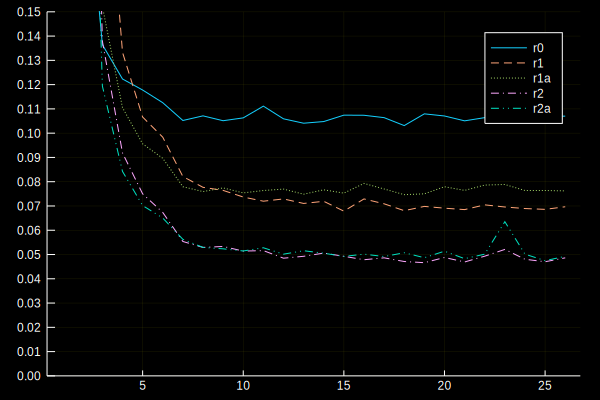

In [122]:
using Plots
plot([r0.errors, r1.errors, r1a.errors, r2.errors, r2a.errors]; 
    ylim=(0,0.15), yticks=0:0.01:0.15, labels=["r0","r1","r1a","r2","r2a"], 
    linestyle=:auto,bg=:black,gridcolor=:yellow,grid=true)

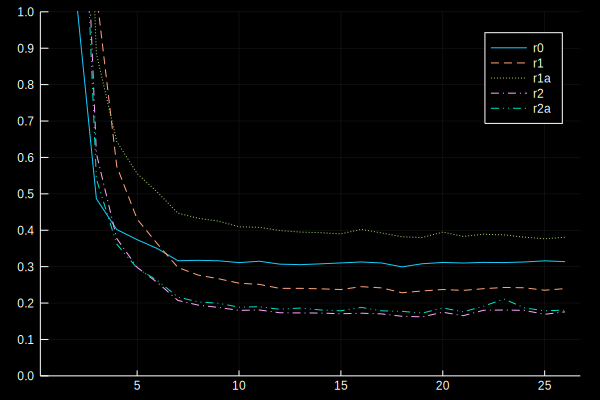

In [123]:
using Plots
plot([r0.losses, r1.losses, r1a.losses, r2.losses, r2a.losses]; 
    ylim=(0,1), yticks=0:0.1:1, labels=["r0","r1","r1a","r2","r2a"], 
    linestyle=:auto,bg=:black,grid=true)

In [118]:
r1a.errors

1-element Array{Array{Float64,1},1}:
 [0.99248, 0.459473, 0.152197, 0.110498, 0.0956055, 0.0896484, 0.0779297, 0.0759277, 0.0774414, 0.0753906  …  0.077002, 0.0746582, 0.075, 0.0779297, 0.076416, 0.0786133, 0.0788574, 0.0763672, 0.0763672, 0.0762207]

In [119]:
r1.errors

1-element Array{Array{Float64,1},1}:
 [1.0, 0.539844, 0.237061, 0.133301, 0.106641, 0.0983398, 0.0821289, 0.0776855, 0.076416, 0.0736816  …  0.0708984, 0.0680664, 0.0698242, 0.0690918, 0.0685059, 0.070459, 0.0695801, 0.0689453, 0.0686035, 0.0696777]

In [120]:
#= 128
5-element Array{Float64,1}:
 0.10292968749999998
 0.07744140624999996
 0.095458984375     
 0.05190429687499998
 0.055908203125    
256
5-element Array{Float64,1}:
 0.10273437500000004 
 0.06855468750000004 
 0.084228515625      
 0.050097656249999956
 0.049267578125000044
512
5-element Array{Float64,1}:
 0.10312500000000002
 0.06787109375      
 0.07465820312500004
 0.046630859375     
 0.04746093750000002
=#
minimum.(x.errors[1] for x in (r0,r1,r1a,r2,r2a))

5-element Array{Float64,1}:
 0.10312500000000002
 0.06787109375      
 0.07465820312500004
 0.046630859375     
 0.04746093750000002

In [121]:
# try dropout
# try 256 hidden
minimum.((r0.losses..., r0.errors...))

(0.2994007468223572, 0.10312500000000002)